# Генерация музыки рекуррентными сетями

Создание новых образов, генерация, возможно, конечно, не только для картинок, но и для любых других типов данных.

В фильме "Я - робот" спросили, [Робот сочинит симфонию](https://www.youtube.com/watch?v=frnEAIa4CzI)? Сегодня мы можем уверенно сказать, что да, компьютер может сочинять музыку, писать стихи, рисовать картины.

Конечно, создание, генерация музыки, это сложная задача, но она решается уже довольно давно. Самый, пожалуй, простой способ, это иметь записанные кусочки хорошей музыки и составлять из них новую музыку. Так работали первые системы генерации музыки.

Если представить музыку как последовательность (нот, звуков или других символов), то можно применить нейронные сети для такой генерации, чем мы и займемся сегодня.



## Представление музыки
Сначала нужно определить, как представлять музыку для компьютера. Будем использовать [ABC нотацию (разметку)](https://ru.wikipedia.org/wiki/ABC_(язык_разметки)) в которой используются обычные символы алфавита для представления нот и музыкальных значков: C, D, E, F, G, A, B (до, ре, ми, фа, соль, ля, си) и другие символы для управляющих последовательностей. Пример такой записи:
```
X:1
T:The Legacy Jig
M:6/8
L:1/8
R:jig
K:G
GFG BAB | gfg gab | GFG BAB | d2A AFD |
GFG BAB | gfg gab | age edB |1 dBA AFD :|2 dBA ABd |:
efe edB | dBA ABd | efe edB | gdB ABd |
efe edB | d2d def | gfe edB |1 dBA ABd :|2 dBA AFD |]
```
и визуальное представление
![img](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Legacy_jig.png/1920px-Legacy_jig.png)

Теперь вся музыка представлена в виде последовательности символов, а значит, мы можем генерировать такие последовательности самостоятельно с помощью нейронной сети.

Более сложное представление, которое позволяет имитировать работу музыкальных инструментов (включая регулирование громкости, выбор тембра и т.п.)  - это формат [MIDI](https://ru.wikipedia.org/wiki/MIDI), который стал стандартом для цифровой звукозаписи. Чтобы сконвертировать ABC представление в MIDI будем пользоваться программой abcmidi и timidity для воспроизведения MIDI или конвертации в MP3 (другой стандарт).

Для упрощения  работы с музыкой будем пользоваться библиотекой `mitdeeplearning` разработанной для замечательного [курса по глубокому обучению](http://introtodeeplearning.com) и TensorFlow для нейронных сетей.

In [1]:

# устанавливаем и подключаем библиотеку  MIT 6.S191
!pip install mitdeeplearning

# программы для конвертации ABC в MIDI представление и воспроизведения.
!apt-get install abcmidi timidity abcm2ps > /dev/null 2>&1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.6.1-py3-none-any.whl size=2118512 sha256=4dbdce7178fd3dc800e8b33cab956247b3c4a509a699dba4ea1ba7b905353f40
  Stored in directory: /root/.cache/pip/wheels/a1/67/db/909c55e80ce7fc2a8dbe1bbff0e591a69d12d11136b4cfe34c
Successfully built mitdeeplearning


In [2]:
import mitdeeplearning as mdl
import tensorflow as tf
# подключаем другие библиотеки
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm # красивое оформление циклов

## Набор данных для обучения и проверки
Для обучения нейронной сети нам нужны примеры музыки в ABC формате. Загрузим набор
(Let's Dance!). Он состоит из примерно тысячи отрывков Ирландской фолк-музыки (Irish folk) в ABC формате.


In [3]:
# загружаем набор данных
songs = mdl.lab1.load_training_data()

# Печатаем одну композицию из него
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Сконвертируем ABC формат в аудио файл и прослушаем (ждите)
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

Все загруженные композиции переведем в одну длинную строку, найдем все уникальные символы в ней, они потребуются для перевода символов в числа.

In [5]:
# объединяем список строк в одну строку
songs_joined = "\n\n".join(songs)

# ищем уникальные символы
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## Предобработка
При генерации мы хотим по предыдущим символам в строке предсказать следующие. Для компьютера нужно перевести все символы в числа и сформировать обучающие пары (вход, выход).

In [6]:
# Перевод символа в его номер в словаре.  ,
# Например для символа "d" вызываем `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Перевод числа (номера в словаре) в символ.
idx2char = np.array(vocab)

In [7]:
print('{')
for char,_ in zip(char2idx, range(len(char2idx))):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  '8' :  20,
  '9' :  21,
  ':' :  22,
  '<' :  23,
  '=' :  24,
  '>' :  25,
  'A' :  26,
  'B' :  27,
  'C' :  28,
  'D' :  29,
  'E' :  30,
  'F' :  31,
  'G' :  32,
  'H' :  33,
  'I' :  34,
  'J' :  35,
  'K' :  36,
  'L' :  37,
  'M' :  38,
  'N' :  39,
  'O' :  40,
  'P' :  41,
  'Q' :  42,
  'R' :  43,
  'S' :  44,
  'T' :  45,
  'U' :  46,
  'V' :  47,
  'W' :  48,
  'X' :  49,
  'Y' :  50,
  'Z' :  51,
  '[' :  52,
  ']' :  53,
  '^' :  54,
  '_' :  55,
  'a' :  56,
  'b' :  57,
  'c' :  58,
  'd' :  59,
  'e' :  60,
  'f' :  61,
  'g' :  62,
  'h' :  63,
  'i' :  64,
  'j' :  65,
  'k' :  66,
  'l' :  67,
  'm' :  68,
  'n' :  69,
  'o' :  70,
  'p' :  71,
  'q' :  72,
  'r' :  73,
  's' :  74,
  't' :  75,
  'u' :  7

In [8]:
# Переводим строку в числа
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [9]:
# смотрим, что получилось
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))

assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Создание обучающих примеров

Наша задача - генерация, предсказание следующих символов.

Тогда входом будет последовательность, а желаемым выходом - та же последовательность, но смещенная на 1 символ в будущее.

Например, исходная строка была "Hello", тогда входная последовательность это "Hell" (она обрезана с конца на 1 символ, чтобы размер входной и выходной последовательности был одинаковый). А выходная, целевая, последовательность это "ello".

Из всей исходной строки музыки берем более короткие подпоследовательности, количество символов в них регулируется `seq_length`. В одном пакете данных содержится `batch_size` таких подпоследовательностей.

В результате из одной длинной строки получится много коротеньких пакетов с примерами входов\выходов размером `batch_size` * `seq_length`

Для большей общности будем выбирать подпоследовательности, начиная со случайного индекса, тогда все пакеты будут перемешаны и не будет такого, что одни пакеты всегда содержат начала музыкального произведения, а другие концы.

Оформим создание пакетов в виде функции, которую затем будем вызывать.

In [10]:
### Создание пакетов обучающих данных ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # длина последовательности
  n = vectorized_songs.shape[0] - 1
  # случайно выбираем индексы начала подпоследовательностей
  idx = np.random.choice(n-seq_length, batch_size)
  # примеры входов, начинаются со случаного индекса, заданной длины
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  # примеры выходов, начинаются с того же индекса плюс один, длина таже
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # переформатируем как пакеты заданного размера
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Несколько тестов, что функция работает верно
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [11]:
# Пакет из одного примера с подпоследовательностью длиной 5
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 64 ('i')
  expected output: 67 ('l')
Step   1
  input: 67 ('l')
  expected output: 70 ('o')
Step   2
  input: 70 ('o')
  expected output: 73 ('r')
Step   3
  input: 73 ('r')
  expected output: 0 ('\n')
Step   4
  input: 0 ('\n')
  expected output: 51 ('Z')


## Создание рекуррентной нейронной сети для генерации музыки

Используем уже известную нам LSTM сеть для работы с последовательностями.  Выход LSTM слоя подаем на полносвязный слой, задача которого определить следующий символ.

Используем Keras API, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), и зададим слои:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): слой векторизации, который переводит символ  с помощью настраиваемой просмотровой таблицы (lookup table)  в вектор длиной `embedding_dim`.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Сам LSTM слой, количество нейронов `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): полносвязный слой, раз он должен для каждого возможного символа предсказать уровень уверенности, то размер слоя определяется размером словаря `vocab_size`.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

In [12]:
# Настройки слоя LSTM
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units, # число нейронов
    return_sequences=True, # возвращает всю последовательность
    recurrent_initializer='glorot_uniform', # способ инициализации вентиля
    recurrent_activation='sigmoid', # функция активации вентиля
    stateful=True, # запоминает состояние
  )

In [13]:
# Создаем модель нейронной сети

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Слой 1: векторизатор
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    # Слой 2: LSTM
    LSTM(rnn_units),
    # Слой 3: полносвязный
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

# Создаем модель с заданными параметрами.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5353299 (20.42 MB)
Trainable params: 5353299 (20.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Проверки работоспособности
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


Размерности массивов правильные!

## Проверка предсказания необученной модели

Проверим, что генерирует необученная модель, похоже ли это на музыку в ABC формате.

Наша нейронная сеть предсказывает уровни уверенности для следующих символов в последовательности, но какие из символов надо брать?

Один вариант - брать такие символы, для которых уровень уверенности максимальный. Но в таком варианте будет очень маленькое разнообразие генерируемых мелодий, что не очень полезно.

Поэтому мы воспользуемся другим вариантом, давайте будем выбирать предсказанные символы _случайно_, но вероятность отбора свяжем с предсказанным уровнем уверенности, чем больше уровень, тем чаще будет выбираться такой символ. Случайность позволяет разнообразить сгенерированную мелодию, в разных примерах даже при одинаковых уровнях уверенности могут отобраться разные символы.

Такой подход использует категориальное распределение вероятностей [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) и функцию softmax для его расчета.

В качестве задания проверьте дальнейшую работу и для первого варианта, когда отбираем самый уверенный символ (используйте argmax).



In [16]:
# выбираем индексы символов случайно из категориального распределения, определяемого уровнями уверенности
sampled_indices = tf.random.categorical(pred[0], num_samples=1) # pred[0] содержит уровни уверенности символов, создаем один случайный пример
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy() # переводим в целые numpy
sampled_indices # запустите несколько раз, убедитесь, что индексы каждый раз разные

array([56, 25, 79, 48, 40, 22, 67, 34, 18, 57, 41, 37,  2,  5, 39, 20, 33,
       33, 64, 12,  0, 67, 20, 45, 78, 51, 75,  3, 55, 73, 72, 28, 18, 14,
       44, 51, 77, 52, 51, 42, 16, 41, 32, 51, 44, 17, 76,  1, 41, 63, 18,
       19, 12, 52, 37, 52, 16,  4, 43, 60, 61, 13, 74, 37,  2, 76, 71, 14,
       60, 26, 51, 23, 62,  0, 14, 28, 31, 73, 23, 33, 18, 27,  0,  8, 13,
       68,  7, 54, 73, 58, 48, 71, 40, 27, 20, 15,  1,  4, 76, 69])

Переведем индексы обратно в символы:

In [17]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 "242\nT:Miss Thornton's\nZ: id:dc-reel-222\nM:C\nL:1/8\nK:G Major\nBA|G2Bd gdBd|cBAB cedc|BGAF GBdg|ecAF GF"

Next Char Predictions: 
 'a>xWO:lI6bPL!\'N8HHi0\nl8TwZt"_rqC62SZv[ZQ4PGZS5u Ph670[L[4#Ref1sL!up2eAZ<g\n2CFr<H6B\n,1m)^rcWpOB83 #un'


Как и ожидалось, в результате получили мусорный текст, который никак не похож на ABC формат музыки. Значит надо обучить сеть!

## Обучение сети
Архитектура сети задана, нужно сформулировать функцию ошибки и метод обучения. Здесь наша задача - предсказание следующего символа - это, по сути, обычная классификация (класс = символ). Используем, например, функцию ошибки для классификации  [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy), которая работает с целочисленными представлениями классов. Здесь `labels` -- цели, т.е. указания учителя, это индексы класса, целые числа, нам не надо самостоятельно делать one-hot представления для них. `logits` -- предсказанные значения уровней уверенности, это вектора размерности 83 (по числу символов в словаре).

In [18]:
# Функция ошибки
# аргумент from_logits=True говорит, что предсказанные значения это именно уровни уверенности (логиты), т.е. не пропущены через softmax
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss
# проверим работу
example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean()) # среднее значение ошибки для пакета

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4188523


Осталось задать гиперпараметры обучения и метод обучения.

In [19]:
# гиперпараметры

# Параметры оптимизации:
num_training_iterations = 5000 #20000  # количество эпох обучения
batch_size = 64  # размер пакета (попробуйте от 1 до 64)
seq_length = 150  # размер подпоследовательности (попробуйте от 50 до 500)
learning_rate = 1e-3  # шаг обучения (попробуйте от 1e-5 до 1e-1)

# Параметры модели:
vocab_size = len(vocab) # размер словаря = число символов
embedding_dim = 256 # размерность входных векторов
rnn_units = 1024  # число рекуррентных нейронов (1 до 2048)

# Директории и префикс для сохранения промежуточных этапов обучения:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Воспользуемся методом обучения [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable), попробуйте и другие, например [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

Чтобы сообщить Keras, что нужно использовать автодифференцирование, используем [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

Также будем печатать промежуточные результаты.

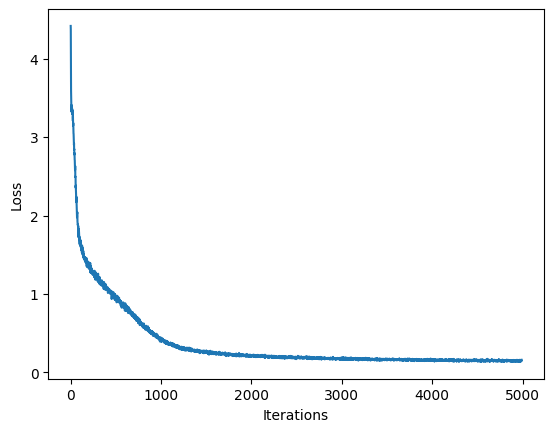

100%|██████████| 5000/5000 [09:18<00:00,  8.95it/s]


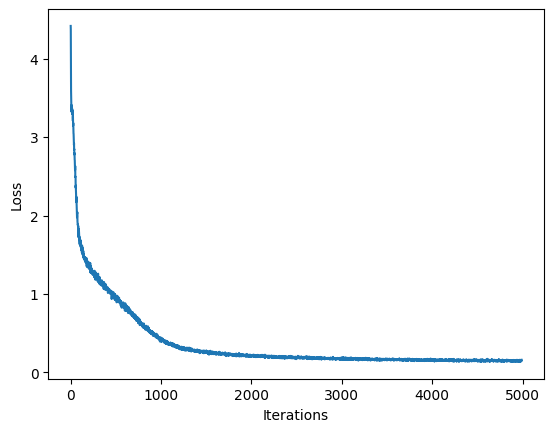

In [20]:
# Создание модели с заданными параметрами
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# Оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate)

# функция ниже будет скопмилирована в граф tensorflow, поддерживающий автодифференцирование
@tf.function
# Функция для одного шага обучения, принимает входы x и желаемые выходы y
def train_step(x, y):
  # используем автодифференцирование  tf.GradientTape()
  with tf.GradientTape() as tape:
    y_hat = model(x) # предсказанные выходы
    loss = compute_loss(y, y_hat) # ошибка обучения
    # градиент ошибки
    grads = tape.gradient(loss, model.trainable_variables) #
  # применяем градиент для одного шага оптимизации
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss # возвращаем ошибку

##################
# ОБУЧЕНИЕ!#
##################

history = []
# график
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
# tqdm - средство для красивого оформления циклов, очищаем, если был раньше.
if hasattr(tqdm, '_instances'): tqdm._instances.clear() #

# цикл до максимального числа итераций
for iter in tqdm(range(num_training_iterations)):

  # создаем обучающий пакет
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  # обучаем сеть на этом пакете
  loss = train_step(x_batch, y_batch)

  # обновляем график, историю
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # временами сохраняем текущие веса модели
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# сохраняем обученную модель
model.save_weights(checkpoint_prefix)


## Генерация музыки

Теперь мы готовы сгенерировать музыку, напомним, что мы будем генерировать ее случайно,  используя  `softmax` для распределения уровней уверенности в символах. Получим строку формата ABC.  

Должны получить. Но может случиться так, что сгенерированная последовательность символов нарушает формат ABC. Особенно при плохо обученных сетях. Тогда и музыки никакой не услышим.

Действительно, мы никак не контролируем формат ABC строки. Например, в ней есть поле с названием мелодии, которое тоже участвует в обучении и генерации (зачем????). Конечно, в более продвинутых программах нужно контролировать форматы файлов, но здесь, при выбранных нами параметрах в большинстве случаев должно все работать корректно.



### Загрузка обученной модели

Генерация похожа на обучение, но и отличается от него.

Во-первых, теперь нам нужен размер пакета `batch_size`=1, потому что мы генерируем следующий символ по предсказанному предыдущему. Придется перестроить модель и загрузить в нее обученные веса, но мы же их сохранили!


In [21]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # размер пакета 1

# загружаем веса из сохраненных
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
# убедимся, что это та же самая модель
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5353299 (20.42 MB)
Trainable params: 5353299 (20.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Видим, размер пакета `batch_size` = 1 (первое измерение в Output Shape).

### Генерация

* Генерацию нужно с чего-то начать, начальных символов, инициализируем их. Также нужно инициализировать состояние рекуррентной сети. Другая инициализация - и результат будет другой.  

* Используя предыдущие сгенерированные (или начальные для первых шагов) символы, предсказываем уровни уверенности следующего символа. Выбираем случайно из категориального распределения с этими уровнями уверенности следующий символ. Это важное отличие генерации от обучения - мы **используем ранее сгенерированные символы для предсказания следующих**, тогда как в обучении предыдущие символы нам были уже известны.

* Не забываем обновлять состояние рекуррентной сети.

Так, постепенно, символ за символом, генерируем нашу мелодию.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)


In [22]:
# Генерация строки

def generate_text(model, start_string, generation_length=1000):
  # начальная строка, переведенная в числа
  input_eval = [char2idx[s] for s in start_string] # TODO
  # конвертируем в тензор нужной размерности
  input_eval = tf.expand_dims(input_eval, 0)

  # Пустая строка результата генерации
  text_generated = []

  # batch size == 1
  model.reset_states() # сбрасываем (т.е. инициализируем) состояние рекуррентой сети
  tqdm._instances.clear() #  и счетчика цикла

  for i in tqdm(range(generation_length)): # в цикле по количеству символов, которые хотим получить
      # считаем выходы сети - уровни уверенности символов
      predictions = model(input_eval)

      # удаляем измерение пакетов
      predictions = tf.squeeze(predictions, 0)
      # выбираем предсказанный символ случайно из категориального распределения
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Для следующей итерации он будет входом
      input_eval = tf.expand_dims([predicted_id], 0)
      # добавляем предсказанный символ к сгенерированной строке
      text_generated.append(idx2char[predicted_id])
  return (start_string + ''.join(text_generated))

In [25]:
# ABC файлы начинаются с символа "X", с него и начнем генерацию.
generated_text = generate_text(model, start_string="X", generation_length=2000) # генерируем


100%|██████████| 2000/2000 [00:16<00:00, 118.38it/s]


In [26]:
generated_text

"X:128\nT:Paddy Fahey's\nZ: id:dc-reel-258\nM:C\nL:1/8\nK:D Minor\nD>A|Beed efed|Beed efge|fedf e2ed|!\nefed BcdB|ABAG EFDe|fded cAAG|EFGE D2Bd|!\nedeg a2bg|a2bg aged|efge dBG|]!\n\nX:319\nT:Sailing into Walpol's\nZ: id:dc-reel-286\nM:C\nL:1/8\nK:E Dorian\ned|BEE2 BAFA|D2FA DAFA|BEE2 BAFA|dBAF D3E|FB|AFEF D2:|!\nde|faag fgfe|defd efdB|A2FA BdAF|EDEF E2de|!\nfaag fgfe|defd efdB|A2F2 ABde|fage d2:|!\nef|g2fg eBB2|gBB2 deg2|bgaf gedB|AGFG ABc|]!\nA|Bdgd Bdgd|Bdgd BGGB|Ac=fc Acfc|Ac=fc A=FFA|!\nBdgd Bdgd|Bdef gfga|bgaf gedB|AGFG ABc|]!\n\nX:112\nT:Flower of the Flock\nZ: id:dc-reel-104\nM:C\nL:1/8\nK:G Major\nGE|DEGA BGGB|cABG AGEG|DEGA BABc|dBAB G2:|!\nBd|g3e d3B|cABG AGEG|g3e d2Bd|eaab agef|!\ng3e d3B|cABG AGEG|DEGA BABc|dBAge d2:|!\n\nX:53\nT:Chocarolan's Crior\nZ: id:dc-oreel-27\nM:C\nL:1/8\nK:D Major\nA2FA A2dB|A2FA BEE2|A2FA A2Bd|egfd ecdB|!\nA2FA A2dB|A2FA BEEF|DEFG AFAB|defd ecdB|]!\nADFD A2dB|ADFA BEE2|ADFD A2Bd|egfd ecdB|!\nADFD A2dB|ADFA GEBG|A3B d2B d2B|A3 ABd|e3 edB|d3-d2:|!\n

## Слушаем музыку!

Сконвертируем ABC строку в мелодию. Если не получается ничего услышать, возможно формат был нарушен, попробуйте лучше обучить сеть, увеличить количество эпох, перезапустить генерацию.

Функция пытается найти в сгенерированной строке подстроки, которые по формату похожи на ABC, конкретно по регулярному выражению: `(^|\n\n)(.*?)\n\n` . Их может быть несколько.

In [27]:
# эта функция пытается найти в строке подстроки, которые по формату похожи на ABC.
# конкретно по регулярному выражению: '(^|\n\n)(.*?)\n\n'
# Их может быть несколько
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # создаем звук из символов
  waveform = mdl.lab1.play_song(song)
  print(i,waveform)
  # если формат правильный, звук не пустой, то его можно воспроизвести
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# выбранную ABC строку можно сохранить в файл
mdl.lab1.save_song_to_abc(generated_songs[0],filename='out')

'out'

# Задания
Улучшите музыку путем увеличения времени обучения, выбором других значений гиперпараметров. Проверьте влияние начальной строки на генерацию, изменяйте ее.


Порадуйте учителя музыки, какие вы великие композиторы.

Примеры генерации музыки другими сетями, предназначенными для работы с текстом, можно найти [здесь](https://www.gwern.net/GPT-2-music).

# Ссылки
Использованы и адаптированы материалы:



*   © MIT 6.S191: Introduction to Deep Learning
http://introtodeeplearning.com
*  https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html#Play-back-the-generated-music!
* https://colab.research.google.com/notebooks/magenta/performance_rnn/performance_rnn.ipynb





TODO: проверить на падения. Подозрения на ipythondisplay.Audio()

In [ ]:
def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    suf = abc_file.rstrip('.abc')
    cmd = "abc2midi {} -o {}".format(abc_file, suf + ".mid")
    os.system(cmd)
    cmd = "timidity {}.mid -Ow {}.wav".format(suf, suf)
    return os.system(cmd)

def play_wav(wav_file):
    return ipythondisplay.Audio(wav_file)

def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename + '.abc')
    if ret == 0: #did not suceed
        return play_wav(basename+'.wav')
    return None

In [ ]:
play_song(generated_songs[0])


Output hidden; open in https://colab.research.google.com to view.